In [1]:
import json
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import matplotlib.pyplot as plt

# 1st battery of experiments

In [641]:
with open(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\results\final_dataset_results_1st_battery.json', 'r') as file:
    results = json.load(file)

rows = []

for dataset_name, methods in results.items():
    for method, values in methods.items():
        rows.append([dataset_name, method, values[0][0], values[1][0],values[2][0],values[3][0],values[4][0],values[5][0]])

df = pd.DataFrame(rows, columns=['dataset', 'method', 'RI', 'CH','FM', 'VS', 'SS','DB'])

In [642]:
metrics = ["RI", "CH", "FM", "VS", "SS", "DB"]

data = []

# Iterar sobre os datasets e métodos
for dataset, methods in results.items():
    for method, values in methods.items():
        row = [dataset, method] + [value[0][1] for value in values]
        data.append(row)

# Criar o DataFrame com colunas dinâmicas
columns = ["Dataset", "Method"] + metrics
df = pd.DataFrame(data, columns=columns)

# Retirando resultados normalizados, pegando apenas os valores brutos
mask = ~df['Dataset'].str.contains('_norm')

df_filtered = df[mask]

df = df_filtered

# Definindo os métodos e as colunas
methods = ['KISOMAP', 'ISOMAP', 'Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']
statistics = []

# Iterando sobre todas as combinações de métricas e métodos
for metric in metrics:
    if '_norm' not in df['Dataset'].unique():
        kiso_data = df[df['Method'] == 'KISOMAP'][metric]
        raw_data = df[df['Method'] == 'RAW'][metric]
    for method in methods:
        if method != 'KISOMAP' and method != "RAW":  # Comparar com KISOMAP
            other_data = df[df['Method'] == method][metric]
            if len(kiso_data) == len(other_data):  # Certificar-se de que temos o mesmo número de amostras
                # Realizando os testes
                stat, p_value = friedmanchisquare(raw_data, kiso_data, other_data)
                p_values_nemenyi = sp.posthoc_nemenyi_friedman(np.array([raw_data, kiso_data, other_data]).T)
                
                # Armazenando os resultados
                statistics.append({
                    'Metric': metric,
                    'Method': method,
                    'Stat': stat,
                    'P-Value Friedman': p_value,
                    # Esse aqui é o valor do teste do KISOMAP vs. (method)
                    'P-Value Nemenyi': p_values_nemenyi[0][2]
                })

            else:
                print(f'Número de amostras não corresponde entre KISOMAP e {method} para a métrica {metric}')

results_df = pd.DataFrame(statistics)

results_df['Test Friedman'] = results_df['P-Value Friedman'].apply(lambda x: 1 if x < 0.05 else 0)
results_df['Stat'] = results_df['Stat'].apply(lambda x: f"{x:.3f}")
results_df['Test Nemenyi'] = results_df['P-Value Nemenyi'].apply(lambda x: 1 if x < 0.05 else 0)
results_df['P-Value Friedman'] = results_df['P-Value Friedman'].apply(lambda x: f"{x:.3f}")
results_df['P-Value Nemenyi'] = results_df['P-Value Nemenyi'].apply(lambda x: f"{x:.3f}")

results_df = results_df.drop('Stat',axis=1)

In [549]:
results_df[['Method','Metric','P-Value Friedman','P-Value Nemenyi','Test Friedman','Test Nemenyi']].sort_values(['Method','Metric'])

,Method,Metric,P-Value Friedman,P-Value Nemenyi,Test Friedman,Test Nemenyi
6,ISOMAP,CH,0.000,0.006,1,1
30,ISOMAP,DB,0.000,0.000,1,1
12,ISOMAP,FM,0.001,0.949,1,0
0,ISOMAP,RI,0.000,0.852,1,0
24,ISOMAP,SS,0.000,0.001,1,1
18,ISOMAP,VS,0.000,0.997,1,0
7,Kernel PCA,CH,0.000,0.009,1,1
31,Kernel PCA,DB,0.000,0.000,1,1
13,Kernel PCA,FM,0.000,0.987,1,0
1,Kernel PCA,RI,0.000,0.307,1,0


In [550]:
###### Exportar tabela em latex
latex_code = results_df[['Method','Metric','P-Value Friedman','P-Value Nemenyi','Test Friedman','Test Nemenyi']].sort_values(['Method','Metric']).to_latex(index=False)

print(latex_code)

\begin{tabular}{llllrr}
\toprule
             Method & Metric & P-Value Friedman & P-Value Nemenyi &  Test Friedman &  Test Nemenyi \\
\midrule
             ISOMAP &     CH &            0.000 &           0.006 &              1 &             1 \\
             ISOMAP &     DB &            0.000 &           0.000 &              1 &             1 \\
             ISOMAP &     FM &            0.001 &           0.949 &              1 &             0 \\
             ISOMAP &     RI &            0.000 &           0.852 &              1 &             0 \\
             ISOMAP &     SS &            0.000 &           0.001 &              1 &             1 \\
             ISOMAP &     VS &            0.000 &           0.997 &              1 &             0 \\
         Kernel PCA &     CH &            0.000 &           0.009 &              1 &             1 \\
         Kernel PCA &     DB &            0.000 &           0.000 &              1 &             1 \\
         Kernel PCA &     FM &          

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_8712\1937461386.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = results_df[['Method','Metric','P-Value Friedman','P-Value Nemenyi','Test Friedman','Test Nemenyi']].sort_values(['Method','Metric']).to_latex(index=False)


In [643]:
# Fazendo o melt para transformar os dados em formato longo
df_melted = pd.melt(df_filtered, id_vars=['Dataset', 'Method'], 
                    value_vars=['RI',
                                'CH',
                                'FM',
                                'VS', 
                                'SS',
                                'DB'],
                    var_name='metric', value_name='value')

# Pivotando para criar uma tabela com subcolunas para cada métrica e método
df_pivot = df_melted.pivot_table(index='Dataset', 
                                 columns=['metric', 'Method'], 
                                 values='value')

# Trocando os níveis do multi-índice nas colunas
df_pivot = df_pivot.swaplevel(i=0, j=1, axis=1)

# Reordenando os níveis após o swap
df_pivot = df_pivot.sort_index(axis=1)


# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm = df_pivot[['ISOMAP','KISOMAP', 'Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='RI').round(3)

df_gmm.reset_index(inplace=True)  

df_gmm

Method,Dataset,ISOMAP,KISOMAP,Kernel PCA,LLE,Laplacian Eigenmaps,t-SNE,UMAP
metric,,RI,RI,RI,RI,RI,RI,RI
0,Engine1,0.535,0.619,0.599,0.561,0.635,0.556,0.531
1,PhishingWebsites,0.500,0.502,0.500,0.500,0.500,0.500,0.502
2,breast-tissue,0.632,0.637,0.574,0.609,0.622,0.645,0.642
3,car-evaluation,0.483,0.497,0.494,0.482,0.487,0.532,0.481
4,cmc,0.530,0.523,0.559,0.507,0.462,0.520,0.522
5,conference_attendance,0.522,0.602,0.501,0.595,0.630,0.522,0.705
6,diggle_table_a2,0.737,0.794,0.770,0.566,0.703,0.751,0.533
7,hayes-roth,0.500,0.506,0.513,0.498,0.506,0.519,0.500
8,heart-statlog,0.747,0.702,0.629,0.513,0.499,0.511,0.653


In [635]:
summary = {
    "Dataset": ["Média","Mediana","Mínimo","Máximo"],
    "ISOMAP": [np.mean(df_gmm['ISOMAP']['RI']),np.median(df_gmm['ISOMAP']['RI']),np.min(df_gmm['ISOMAP']['RI']),np.max(df_gmm['ISOMAP']['RI'])],
    "KISOMAP": [np.mean(df_gmm['KISOMAP']['RI']),np.median(df_gmm['KISOMAP']['RI']),np.min(df_gmm['KISOMAP']['RI']),np.max(df_gmm['KISOMAP']['RI'])],
    "Kernel PCA": [np.mean(df_gmm['Kernel PCA']['RI']),np.median(df_gmm['Kernel PCA']['RI']),np.min(df_gmm['Kernel PCA']['RI']),np.max(df_gmm['Kernel PCA']['RI'])],
    "LLE": [np.mean(df_gmm['LLE']['RI']),np.median(df_gmm['LLE']['RI']),np.min(df_gmm['LLE']['RI']),np.max(df_gmm['LLE']['RI'])],
    "Laplacian Eigenmaps": [np.mean(df_gmm['Laplacian Eigenmaps']['RI']),np.median(df_gmm['Laplacian Eigenmaps']['RI']),np.min(df_gmm['Laplacian Eigenmaps']['RI']),np.max(df_gmm['Laplacian Eigenmaps']['RI'])],
    "t-SNE": [np.mean(df_gmm['t-SNE']['RI']),np.median(df_gmm['t-SNE']['RI']),np.min(df_gmm['t-SNE']['RI']),np.max(df_gmm['t-SNE']['RI'])],
    "UMAP": [np.mean(df_gmm['UMAP']['RI']),np.median(df_gmm['UMAP']['RI']),np.min(df_gmm['UMAP']['RI']),np.max(df_gmm['UMAP']['RI'])]
}
df_summary = pd.DataFrame(summary)

In [636]:
df_summary.round(3)

,Dataset,ISOMAP,KISOMAP,Kernel PCA,LLE,Laplacian Eigenmaps,t-SNE,UMAP
0,Média,0.764,0.840,0.626,0.740,0.721,0.799,0.834
1,Mediana,0.809,0.890,0.688,0.796,0.740,0.904,0.879
2,Mínimo,0.500,0.518,0.161,0.495,0.495,0.504,0.510
3,Máximo,0.965,0.967,0.915,0.971,0.967,0.981,0.975


In [637]:
###### Exportar tabela em latex
latex_code = df_summary.round(3).to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrrrr}
\toprule
Dataset &  ISOMAP &  KISOMAP &  Kernel PCA &   LLE &  Laplacian Eigenmaps &  t-SNE &  UMAP \\
\midrule
  Média &   0.764 &    0.840 &       0.626 & 0.740 &                0.721 &  0.799 & 0.834 \\
Mediana &   0.809 &    0.890 &       0.688 & 0.796 &                0.740 &  0.904 & 0.879 \\
 Mínimo &   0.500 &    0.518 &       0.161 & 0.495 &                0.495 &  0.504 & 0.510 \\
 Máximo &   0.965 &    0.967 &       0.915 & 0.971 &                0.967 &  0.981 & 0.975 \\
\bottomrule
\end{tabular}



C:\Users\Gustavo\AppData\Local\Temp\ipykernel_8712\3621184971.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_summary.round(3).to_latex(index=False)


In [638]:
###### Exportar tabela em latex
latex_code = df_gmm.round(3).to_latex(index=False)
print(latex_code)

\begin{tabular}{lrrrrrrr}
\toprule
              Dataset & ISOMAP & KISOMAP & Kernel PCA &   LLE & Laplacian Eigenmaps & t-SNE &  UMAP \\
                      &     RI &      RI &         RI &    RI &                  RI &    RI &    RI \\
\midrule
     AP\_Breast\_Kidney &  0.930 &   0.936 &      0.508 & 0.521 &               0.524 & 0.936 & 0.879 \\
AP\_Endometrium\_Breast &  0.500 &   0.720 &      0.737 & 0.854 &               0.535 & 0.603 & 0.791 \\
    AP\_Omentum\_Kidney &  0.502 &   0.937 &      0.640 & 0.535 &               0.703 & 0.640 & 0.852 \\
        AP\_Ovary\_Lung &  0.726 &   0.837 &      0.521 & 0.498 &               0.705 & 0.646 & 0.730 \\
              F-MNIST &  0.887 &   0.942 &      0.872 & 0.878 &               0.873 & 0.904 & 0.905 \\
                MNIST &  0.882 &   0.903 &      0.790 & 0.819 &               0.828 & 0.904 & 0.910 \\
           OVA\_Uterus &  0.501 &   0.612 &      0.850 & 0.782 &               0.502 & 0.532 & 0.612 \\
           Pen-Digit

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_8712\868008869.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_gmm.round(3).to_latex(index=False)


# 2nd Battery of Experiments

In [647]:
# Carregar o arquivo de resultados da primeira bateria de experimentos
with open(r'C:\Users\Gustavo\Documents\Mestrado\curvature-based-isomap\results\final_dataset_results_2nd_battery.json', 'r') as file:
    results = json.load(file)

rows = []

for dataset_name, methods in results.items():
    for method, values in methods.items():
        rows.append([dataset_name, method, values[0][0], values[1][0],values[2][0],values[3][0],values[4][0],values[5][0]])

df = pd.DataFrame(rows, columns=['dataset', 'method', 'RI', 'CH','FM', 'VS', 'SS','DB'])

In [648]:
metrics = ["RI", "CH", "FM", "VS", "SS", "DB"]

data = []

# Iterar sobre os datasets e métodos
for dataset, methods in results.items():
    for method, values in methods.items():
        row = [dataset, method] + [value[0][1] for value in values]
        data.append(row)

# Criar o DataFrame com colunas dinâmicas
columns = ["Dataset", "Method"] + metrics
df = pd.DataFrame(data, columns=columns)

# Retirando resultados normalizados, pegando apenas os valores brutos
mask = ~df['Dataset'].str.contains('_norm')

df_filtered = df[mask]

df = df_filtered

# Definindo os métodos e as colunas
methods = ['ISOMAP','KISOMAP', 'Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']
statistics = []

# Iterando sobre todas as combinações de métricas e métodos
for metric in metrics:
    if '_norm' not in df['Dataset'].unique():
        kiso_data = df[df['Method'] == 'KISOMAP'][metric]
        raw_data = df[df['Method'] == 'RAW'][metric]
    for method in methods:
        if method != 'KISOMAP' and method != "RAW":  # Comparar com KISOMAP
            other_data = df[df['Method'] == method][metric]
            if len(kiso_data) == len(other_data):  # Certificar-se de que temos o mesmo número de amostras
                # Realizando os testes
                stat, p_value = friedmanchisquare(raw_data, kiso_data, other_data)
                p_values_nemenyi = sp.posthoc_nemenyi_friedman(np.array([raw_data, kiso_data, other_data]).T)
                
                # Armazenando os resultados
                statistics.append({
                    'Metric': metric,
                    'Method': method,
                    'Stat': stat,
                    'P-Value Friedman': p_value,
                    # Esse aqui é o valor do teste do KISOMAP vs. (method)
                    'P-Value Nemenyi': p_values_nemenyi[0][2]
                })

            else:
                print(f'Número de amostras não corresponde entre KISOMAP e {method} para a métrica {metric}')

results_df = pd.DataFrame(statistics)

results_df['Test Friedman'] = results_df['P-Value Friedman'].apply(lambda x: 1 if x < 0.05 else 0)
results_df['Stat'] = results_df['Stat'].apply(lambda x: f"{x:.3f}")
results_df['Test Nemenyi'] = results_df['P-Value Nemenyi'].apply(lambda x: 1 if x < 0.05 else 0)
results_df['P-Value Friedman'] = results_df['P-Value Friedman'].apply(lambda x: f"{x:.3f}")
results_df['P-Value Nemenyi'] = results_df['P-Value Nemenyi'].apply(lambda x: f"{x:.3f}")

results_df = results_df.drop('Stat', axis=1)

In [603]:
results_df

,Metric,Method,P-Value Friedman,P-Value Nemenyi,Test Friedman,Test Nemenyi
0,RI,ISOMAP,0.000,0.645,1,0
1,RI,Kernel PCA,0.000,0.272,1,0
2,RI,LLE,0.000,0.542,1,0
3,RI,Laplacian Eigenmaps,0.000,0.352,1,0
4,RI,t-SNE,0.003,0.088,1,0
5,RI,UMAP,0.002,0.004,1,1
6,CH,ISOMAP,0.000,0.006,1,1
7,CH,Kernel PCA,0.000,0.016,1,1
8,CH,LLE,0.000,0.492,1,0
9,CH,Laplacian Eigenmaps,0.000,0.060,1,0


In [604]:
###### Exportar tabela em latex
latex_code = results_df[['Method','Metric','P-Value Friedman','P-Value Nemenyi','Test Friedman','Test Nemenyi']].sort_values(['Method','Metric']).to_latex(index=False)

print(latex_code)

\begin{tabular}{llllrr}
\toprule
             Method & Metric & P-Value Friedman & P-Value Nemenyi &  Test Friedman &  Test Nemenyi \\
\midrule
             ISOMAP &     CH &            0.000 &           0.006 &              1 &             1 \\
             ISOMAP &     DB &            0.000 &           0.000 &              1 &             1 \\
             ISOMAP &     FM &            0.000 &           0.793 &              1 &             0 \\
             ISOMAP &     RI &            0.000 &           0.645 &              1 &             0 \\
             ISOMAP &     SS &            0.000 &           0.010 &              1 &             1 \\
             ISOMAP &     VS &            0.000 &           0.986 &              1 &             0 \\
         Kernel PCA &     CH &            0.000 &           0.016 &              1 &             1 \\
         Kernel PCA &     DB &            0.000 &           0.000 &              1 &             1 \\
         Kernel PCA &     FM &          

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_8712\1937461386.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = results_df[['Method','Metric','P-Value Friedman','P-Value Nemenyi','Test Friedman','Test Nemenyi']].sort_values(['Method','Metric']).to_latex(index=False)


In [649]:
# Fazendo o melt para transformar os dados em formato longo
df_melted = pd.melt(df_filtered, id_vars=['Dataset', 'Method'], 
                    value_vars=['RI',
                                'CH',
                                'FM',
                                'VS', 
                                'SS',
                                'DB'],
                    var_name='metric', value_name='value')

# Pivotando para criar uma tabela com subcolunas para cada métrica e método
df_pivot = df_melted.pivot_table(index='Dataset', 
                                 columns=['metric', 'Method'], 
                                 values='value')

# Trocando os níveis do multi-índice nas colunas
df_pivot = df_pivot.swaplevel(i=0, j=1, axis=1)

# Reordenando os níveis após o swap
df_pivot = df_pivot.sort_index(axis=1)


# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm = df_pivot[['ISOMAP','KISOMAP','Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='SS')
df_gmm.reset_index(inplace=True)  

# Dataset com resultados da métrica escolhida
df_gmm.round(3)

Method,Dataset,ISOMAP,KISOMAP,Kernel PCA,LLE,Laplacian Eigenmaps,t-SNE,UMAP
metric,,SS,SS,SS,SS,SS,SS,SS
0,AP_Breast_Kidney,0.449,0.423,0.978,0.546,0.543,0.514,0.664
1,AP_Endometrium_Breast,0.155,0.207,0.939,0.155,0.103,0.158,0.522
2,AP_Omentum_Kidney,0.192,0.324,0.933,0.117,0.191,0.163,0.553
3,AP_Ovary_Lung,0.271,0.261,0.941,0.218,0.153,0.148,0.489
4,F-MNIST,0.221,0.241,0.097,0.185,0.358,0.243,0.463
5,MNIST,0.121,0.216,0.139,0.082,0.452,0.218,0.431
6,OVA_Uterus,0.208,0.266,0.984,0.393,0.182,0.239,0.368
7,Pen-Digits,0.376,0.444,0.336,0.295,0.588,0.424,0.775
8,USPS,0.207,0.284,0.420,0.121,0.164,0.566,0.661


In [606]:
summary = {
    "Dataset": ["Média","Mediana","Mínimo","Máximo"],
    "ISOMAP": [np.mean(df_gmm['ISOMAP']['DB']),np.median(df_gmm['ISOMAP']['DB']),np.min(df_gmm['ISOMAP']['DB']),np.max(df_gmm['ISOMAP']['DB'])],
    "KISOMAP": [np.mean(df_gmm['KISOMAP']['DB']),np.median(df_gmm['KISOMAP']['DB']),np.min(df_gmm['KISOMAP']['DB']),np.max(df_gmm['KISOMAP']['DB'])],
    "Kernel PCA": [np.mean(df_gmm['Kernel PCA']['DB']),np.median(df_gmm['Kernel PCA']['DB']),np.min(df_gmm['Kernel PCA']['DB']),np.max(df_gmm['Kernel PCA']['DB'])],
    "LLE": [np.mean(df_gmm['LLE']['DB']),np.median(df_gmm['LLE']['DB']),np.min(df_gmm['LLE']['DB']),np.max(df_gmm['LLE']['DB'])],
    "Laplacian Eigenmaps": [np.mean(df_gmm['Laplacian Eigenmaps']['DB']),np.median(df_gmm['Laplacian Eigenmaps']['DB']),np.min(df_gmm['Laplacian Eigenmaps']['DB']),np.max(df_gmm['Laplacian Eigenmaps']['DB'])],
    "t-SNE": [np.mean(df_gmm['t-SNE']['DB']),np.median(df_gmm['t-SNE']['DB']),np.min(df_gmm['t-SNE']['DB']),np.max(df_gmm['t-SNE']['DB'])],
    "UMAP": [np.mean(df_gmm['UMAP']['DB']),np.median(df_gmm['UMAP']['DB']),np.min(df_gmm['UMAP']['DB']),np.max(df_gmm['UMAP']['DB'])]
}
df_summary = pd.DataFrame(summary)

In [607]:
###### Exportar tabela em latex
latex_code = df_summary.round(3).to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrrrr}
\toprule
Dataset &  ISOMAP &  KISOMAP &  Kernel PCA &   LLE &  Laplacian Eigenmaps &  t-SNE &  UMAP \\
\midrule
  Média &   1.767 &    1.762 &       1.044 & 2.131 &                1.418 &  1.699 & 0.807 \\
Mediana &   1.511 &    1.584 &       1.197 & 1.893 &                1.004 &  1.307 & 0.807 \\
 Mínimo &   0.880 &    0.921 &       0.012 & 0.627 &                0.416 &  0.096 & 0.333 \\
 Máximo &   4.598 &    4.845 &       4.931 & 7.874 &                3.338 &  7.449 & 2.180 \\
\bottomrule
\end{tabular}



C:\Users\Gustavo\AppData\Local\Temp\ipykernel_8712\3621184971.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_summary.round(3).to_latex(index=False)


In [608]:
###### Exportar tabela em latex
latex_code = df_gmm.round(3).to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrrrr}
\toprule
              Dataset & ISOMAP & KISOMAP & Kernel PCA &   LLE & Laplacian Eigenmaps & t-SNE &  UMAP \\
                      &     DB &      DB &         DB &    DB &                  DB &    DB &    DB \\
\midrule
     AP\_Breast\_Kidney &  0.942 &   1.077 &      0.019 & 0.764 &               0.443 & 0.753 & 0.528 \\
AP\_Endometrium\_Breast &  2.370 &   2.173 &      0.047 & 2.696 &               3.338 & 2.075 & 0.716 \\
    AP\_Omentum\_Kidney &  2.328 &   1.914 &      0.078 & 2.820 &               2.373 & 2.042 & 0.996 \\
        AP\_Ovary\_Lung &  1.511 &   1.694 &      0.044 & 3.176 &               2.648 & 2.211 & 0.807 \\
              F-MNIST &  1.511 &   1.584 &      1.520 & 1.590 &               1.138 & 1.449 & 0.852 \\
                MNIST &  1.933 &   1.743 &      1.469 & 1.893 &               0.758 & 1.433 & 0.864 \\
           OVA\_Uterus &  1.950 &   2.237 &      0.012 & 0.967 &               2.816 & 1.689 & 0.764 \\
           Pen-Digit

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_8712\1372045903.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_code = df_gmm.round(3).to_latex(index=False)


# Análise gráfica dos resultados

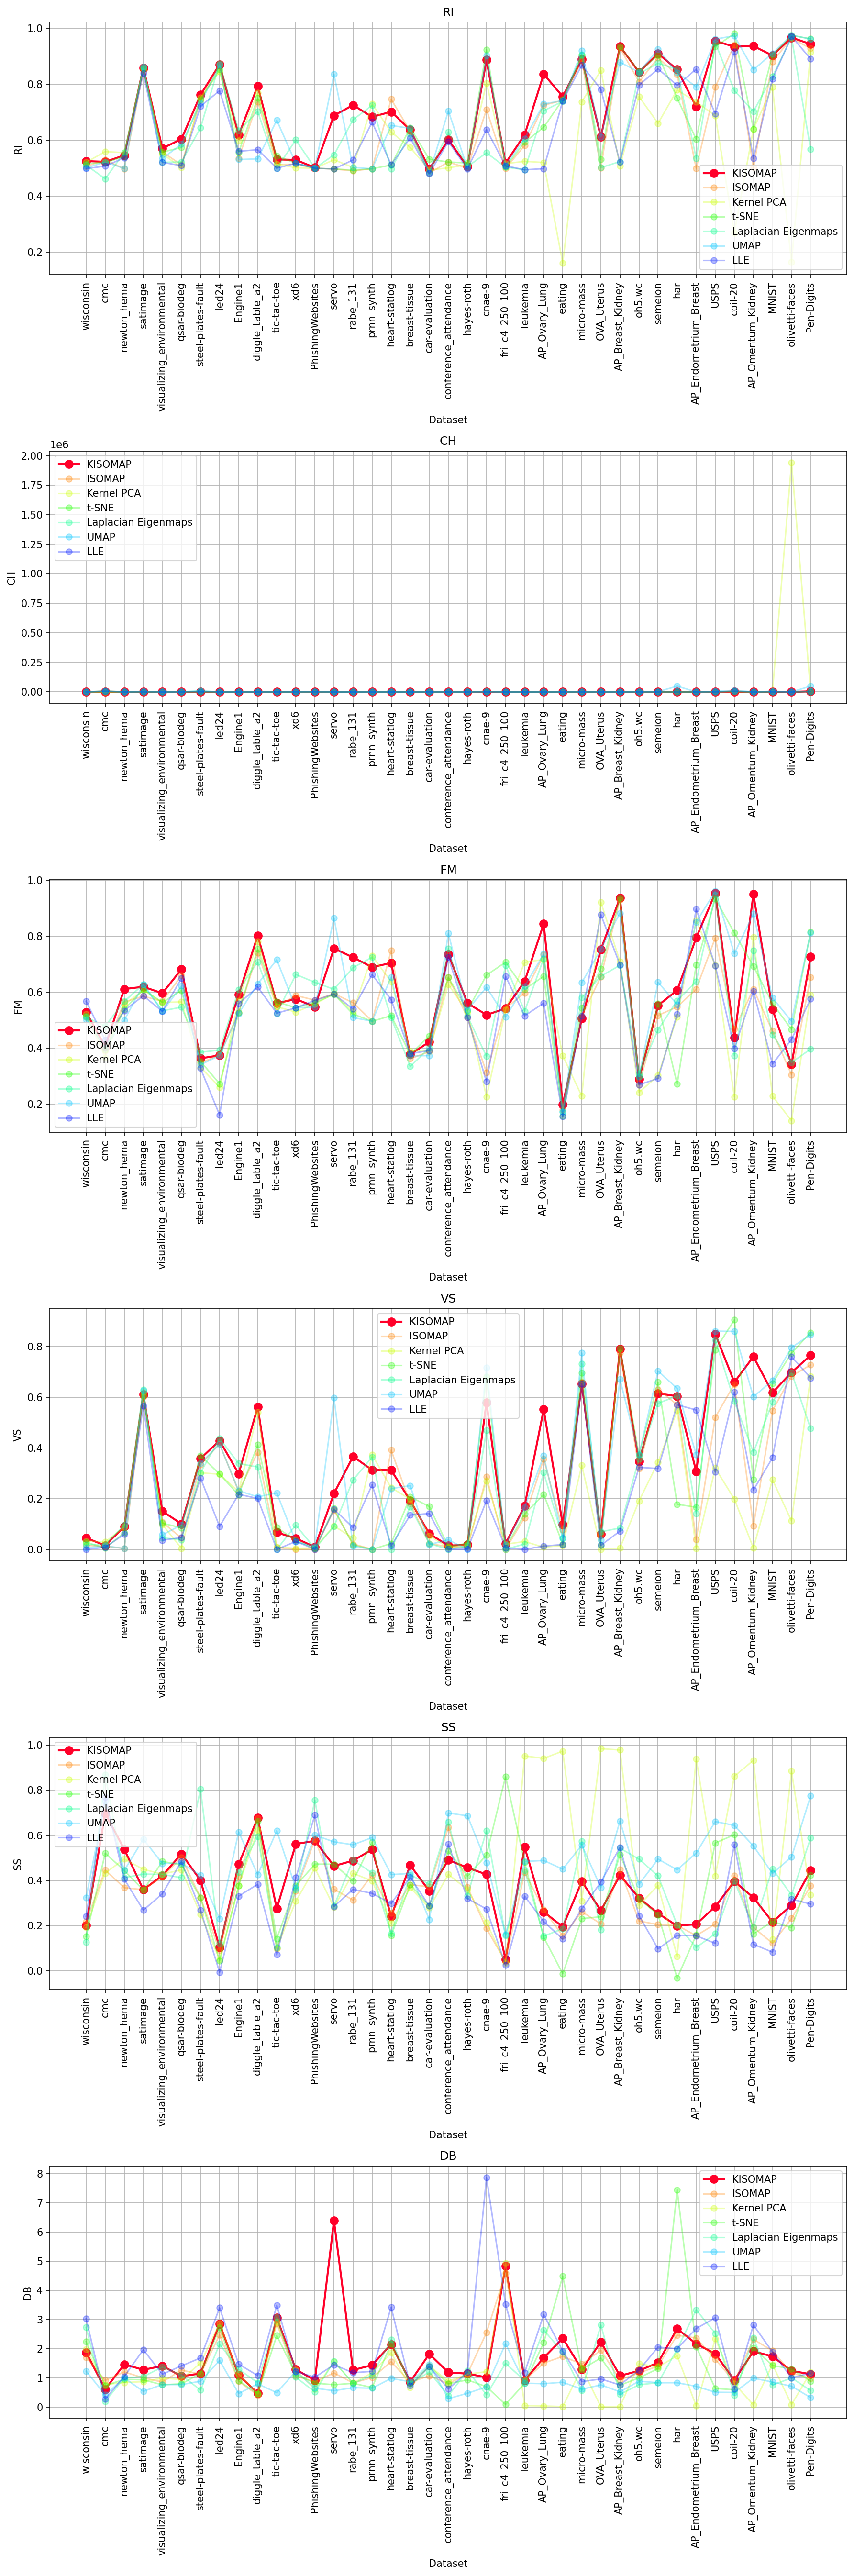

In [385]:
df = df_filtered
# Definir as cores para cada método usando o colormap 'gist_rainbow'
colormap = plt.get_cmap('gist_rainbow')
methods = df['Method'].unique()
colors = {method: colormap(i / len(methods)) for i, method in enumerate(methods)}

# Lista das novas colunas que serão plotadas
metrics = ['RI', 'CH', 'FM', 'VS', 'SS', 'DB']

# Criar a figura com subplots, ajustando o tamanho e DPI
fig, axs = plt.subplots(len(metrics), 1, figsize=(12, 6 * len(metrics)), dpi=150)

for ax, metric in zip(axs, metrics):
    for method in df['Method'].unique():
        subset = df[df['Method'] == method]
        if method == 'KISOMAP':
            ax.plot(subset['Dataset'], subset[metric], 
                    marker='o', label=method, color=colors[method], linewidth=2, markersize=8)
        elif method == 'RAW':
            continue
        else:
            ax.plot(subset['Dataset'], subset[metric], 
                    marker='o', label=method, color=colors.get(method, 'gray'), alpha=0.3)
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')
    ax.grid(True)
    ax.legend()  # Adiciona a legenda
    ax.tick_params(axis='x', rotation=90)  # Rotaciona os rótulos do eixo x se necessário

plt.tight_layout()
plt.show()

# Boxplots

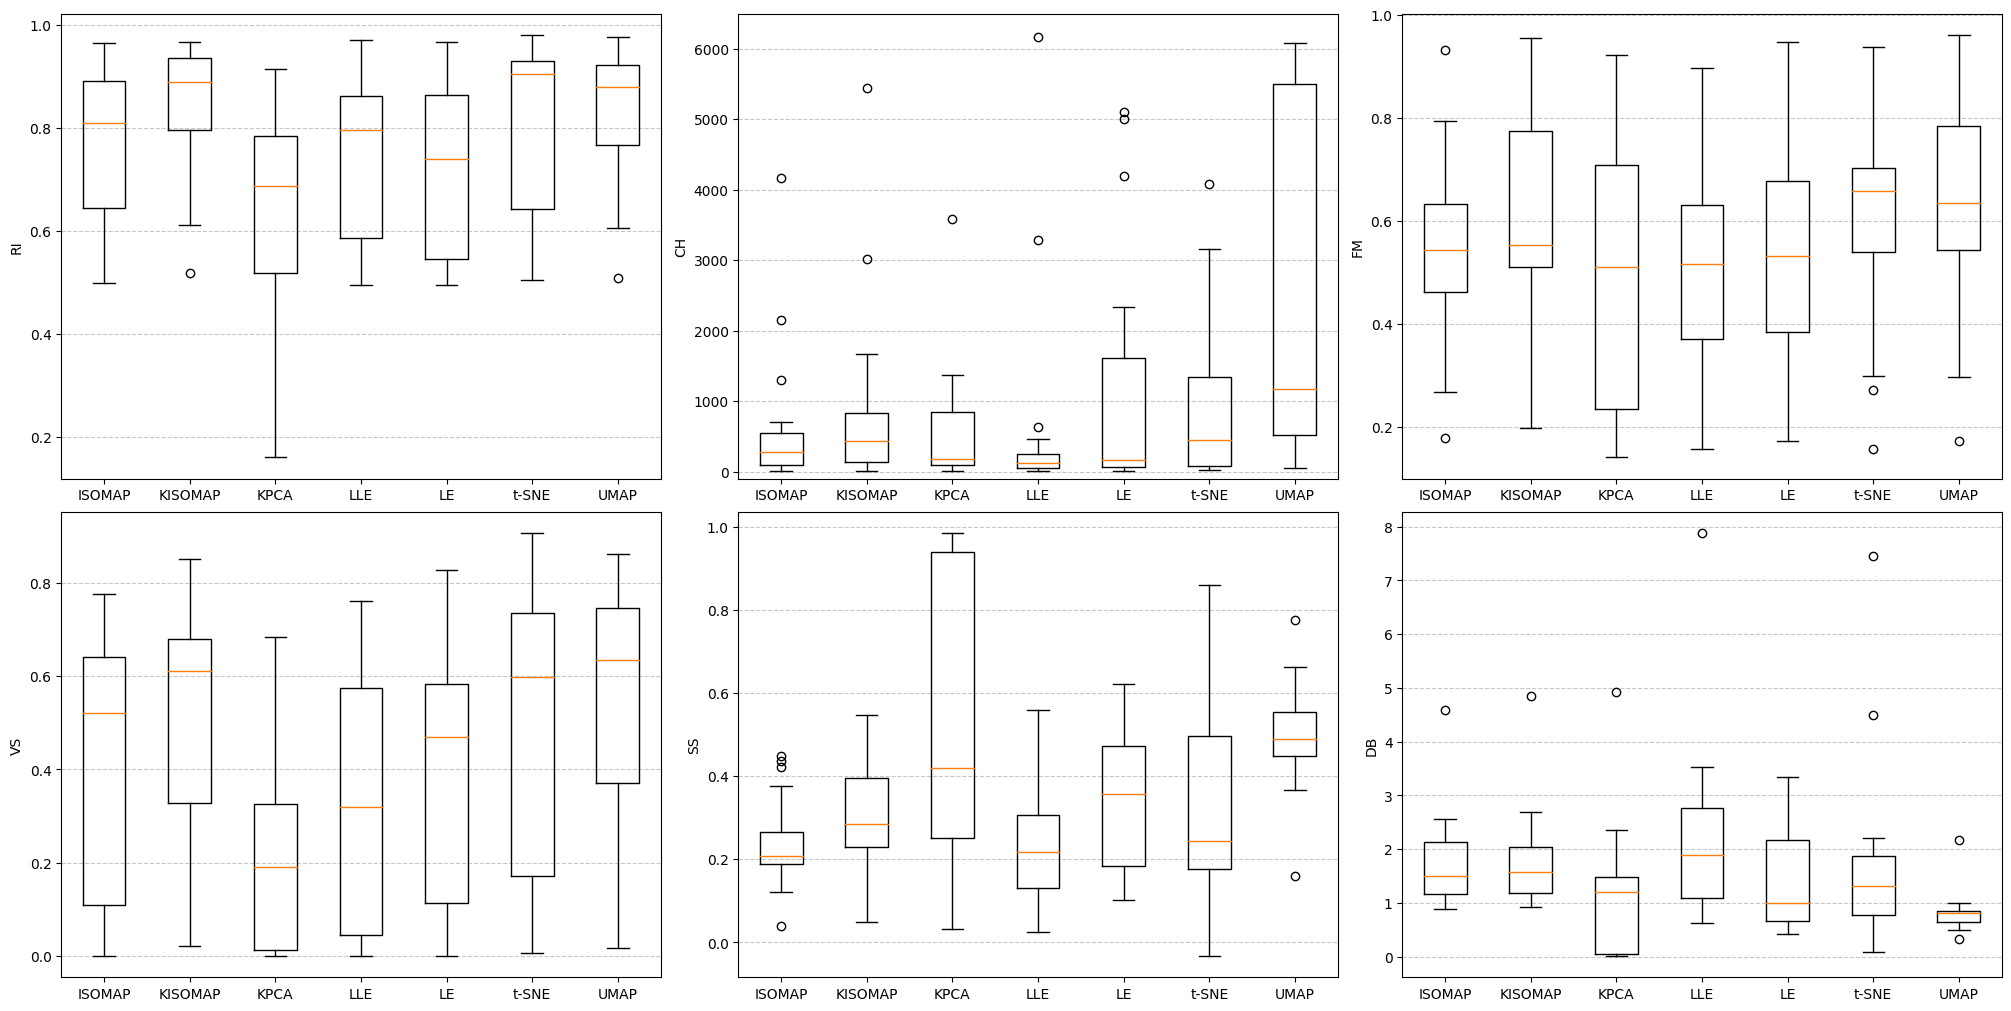

In [654]:
# Nomes das métricas e métodos
metrics = ['RI', 'CH', 'FM', 'VS', 'SS', 'DB']
metrics_name = ['Rand Index', 'Calinski-Harabasz', 'Fowlkes-Mallows', 'V-Score', 'Silhouette Score', 'Davies-Bouldin Index']
methods = ['ISOMAP', 'KISOMAP', 'KPCA', 'LLE', 'LE', 't-SNE', 'UMAP']

# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm_ri = df_pivot[['ISOMAP','KISOMAP','Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='RI')
df_gmm_ri.reset_index(inplace=True)  

# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm_ch = df_pivot[['ISOMAP','KISOMAP','Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='CH')
df_gmm_ch.reset_index(inplace=True)  


# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm_fm = df_pivot[['ISOMAP','KISOMAP','Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='FM')
df_gmm_fm.reset_index(inplace=True)  

# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm_vs = df_pivot[['ISOMAP','KISOMAP','Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='VS')
df_gmm_vs.reset_index(inplace=True)  

# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm_ss = df_pivot[['ISOMAP','KISOMAP','Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='SS')
df_gmm_ss.reset_index(inplace=True)  

# Alterar para adicionar RI, CH, ... para os resultados ficarem agrupados por métrica
df_gmm_db = df_pivot[['ISOMAP','KISOMAP','Kernel PCA','LLE','Laplacian Eigenmaps','t-SNE','UMAP']].filter(like='DB')
df_gmm_db.reset_index(inplace=True)  


# Dados fictícios para cada métrica e método (substitua pelos valores reais)
simulated_data = {
    'RI': [df_gmm_ri[['Dataset','ISOMAP']]['ISOMAP']['RI'],
             df_gmm_ri[['Dataset','KISOMAP']]['KISOMAP']['RI'],
             df_gmm_ri[['Dataset','Kernel PCA']]['Kernel PCA']['RI'],
             df_gmm_ri[['Dataset','LLE']]['LLE']['RI'],
             df_gmm_ri[['Dataset','Laplacian Eigenmaps']]['Laplacian Eigenmaps']['RI'],
             df_gmm_ri[['Dataset','t-SNE']]['t-SNE']['RI'],
             df_gmm_ri[['Dataset','UMAP']]['UMAP']['RI']],
    'CH': [df_gmm_ch[['Dataset','ISOMAP']]['ISOMAP']['CH'],
             df_gmm_ch[['Dataset','KISOMAP']]['KISOMAP']['CH'],
             df_gmm_ch[['Dataset','Kernel PCA']]['Kernel PCA']['CH'],
             df_gmm_ch[['Dataset','LLE']]['LLE']['CH'],
             df_gmm_ch[['Dataset','Laplacian Eigenmaps']]['Laplacian Eigenmaps']['CH'],
             df_gmm_ch[['Dataset','t-SNE']]['t-SNE']['CH'],
             df_gmm_ch[['Dataset','UMAP']]['UMAP']['CH']],
    'FM': [df_gmm_fm[['Dataset','ISOMAP']]['ISOMAP']['FM'],
             df_gmm_fm[['Dataset','KISOMAP']]['KISOMAP']['FM'],
             df_gmm_fm[['Dataset','Kernel PCA']]['Kernel PCA']['FM'],
             df_gmm_fm[['Dataset','LLE']]['LLE']['FM'],
             df_gmm_fm[['Dataset','Laplacian Eigenmaps']]['Laplacian Eigenmaps']['FM'],
             df_gmm_fm[['Dataset','t-SNE']]['t-SNE']['FM'],
             df_gmm_fm[['Dataset','UMAP']]['UMAP']['FM']],
    'VS': [df_gmm_vs[['Dataset','ISOMAP']]['ISOMAP']['VS'],
             df_gmm_vs[['Dataset','KISOMAP']]['KISOMAP']['VS'],
             df_gmm_vs[['Dataset','Kernel PCA']]['Kernel PCA']['VS'],
             df_gmm_vs[['Dataset','LLE']]['LLE']['VS'],
             df_gmm_vs[['Dataset','Laplacian Eigenmaps']]['Laplacian Eigenmaps']['VS'],
             df_gmm_vs[['Dataset','t-SNE']]['t-SNE']['VS'],
             df_gmm_vs[['Dataset','UMAP']]['UMAP']['VS']],
    'SS': [df_gmm_ss[['Dataset','ISOMAP']]['ISOMAP']['SS'],
             df_gmm_ss[['Dataset','KISOMAP']]['KISOMAP']['SS'],
             df_gmm_ss[['Dataset','Kernel PCA']]['Kernel PCA']['SS'],
             df_gmm_ss[['Dataset','LLE']]['LLE']['SS'],
             df_gmm_ss[['Dataset','Laplacian Eigenmaps']]['Laplacian Eigenmaps']['SS'],
             df_gmm_ss[['Dataset','t-SNE']]['t-SNE']['SS'],
             df_gmm_ss[['Dataset','UMAP']]['UMAP']['SS']],
    'DB': [df_gmm_db[['Dataset','ISOMAP']]['ISOMAP']['DB'],
             df_gmm_db[['Dataset','KISOMAP']]['KISOMAP']['DB'],
             df_gmm_db[['Dataset','Kernel PCA']]['Kernel PCA']['DB'],
             df_gmm_db[['Dataset','LLE']]['LLE']['DB'],
             df_gmm_db[['Dataset','Laplacian Eigenmaps']]['Laplacian Eigenmaps']['DB'],
             df_gmm_db[['Dataset','t-SNE']]['t-SNE']['DB'],
             df_gmm_db[['Dataset','UMAP']]['UMAP']['DB']]
} 

# Criando subplots para as métricas
fig, axes = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True)

# Iterando sobre as métricas e eixos para criar os gráficos
for ax, metric in zip(axes.flat, metrics):
    if metric == 'CH':
        data = simulated_data[metric]
        ax.boxplot(data, labels=methods)
        ax.set_ylabel(metric)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(-100, 6500)  # Ajuste para o intervalo desejado
    else:
        data = simulated_data[metric]
        ax.boxplot(data, labels=methods)
        ax.set_ylabel(metric)
        ax.grid(axis='y', linestyle='--', alpha=0.7)        
    

# Exibindo os gráficos
plt.savefig('2nd_battery_boxplots.png',dpi=300)
plt.show()

# Melhores métricas K-ISOMAP

In [ ]:
data = [
    [6, 8, 6, 3, 8, 7],
    [5, 8, 7, 8, 8, 6],
    [4, 8, 1, 1, 8, 0],
    [9, 6, 9, 9, 7, 8],
    [6, 1, 7, 6, 1, 6],
    [10, 7, 3, 7, 6, 2],
    [7, 5, 5, 7, 6, 8],
    [1, 7, 6, 1, 2, 1],
    [6, 6, 0, 0, 6, 3],
    [5, 8, 5, 1, 8, 9],
    [6, 2, 6, 6, 2, 6],
    [8, 2, 8, 8, 7, 8],
    [0, 1, 9, 0, 1, 2],
    [8, 10, 8, 9, 2, 8],
    [6, 1, 8, 6, 8, 7],
    [1, 5, 8, 1, 8, 6],
    [7, 2, 7, 7, 6, 8],
    [6, 2, 1, 6, 2, 8],
    [2, 8, 2, 2, 5, 10],
    [2, 6, 3, 5, 6, 1],
    [1, 1, 1, 8, 1, 3],
    [6, 6, 6, 6, 7, 5],
    [0, 6, 0, 0, 6, 8],
    [2, 6, 7, 7, 6, 3],
    [7, 7, 7, 7, 7, 3],
    [7, 6, 7, 7, 6, 8],
    [6, 0, 0, 6, 1, 7],
    [1, 6, 1, 1, 6, 7],
    [1, 1, 1, 1, 1, 8],
    [7, 6, 7, 7, 6, 3],
    [0, 1, 0, 0, 1, 8],
    [4, 1, 4, 5, 1, 6],
    [6, 0, 6, 6, 10, 7],
    [2, 6, 6, 2, 6, 8],
    [5, 6, 5, 6, 6, 8],
    [0, 8, 0, 9, 8, 9],
    [1, 8, 1, 1, 8, 1],
    [1, 7, 4, 1, 7, 8],
    [0, 6, 0, 0, 6, 0],
    [0, 6, 2, 2, 6, 8]
]

columns = ['RI', 'CH', 'FM', 'VS', 'SS', 'DB']

df = pd.DataFrame(data, columns=columns)

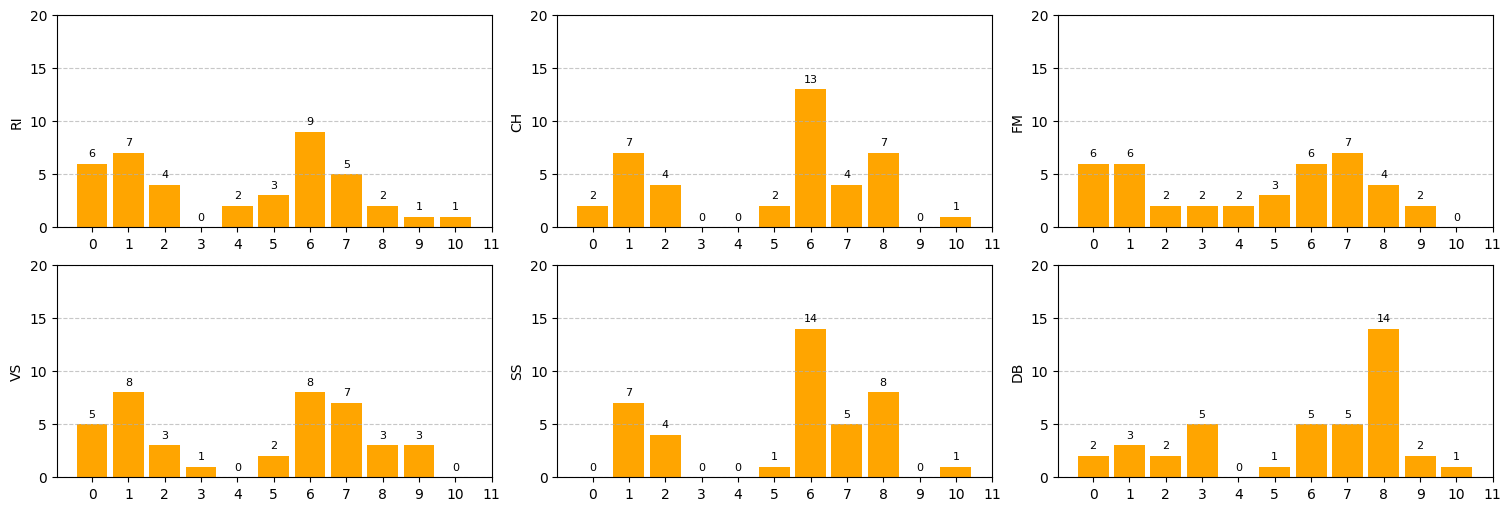

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), constrained_layout=True)

for ax, metric in zip(axes.flat, columns):
    data = df[metric]

    counts, bins, patches = ax.hist(data, bins=range(12), align='left', rwidth=0.85, color='orange')
    ax.set_ylabel(metric)
    ax.set_xticks(range(12))
    ax.set_ylim(0, 20)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for count, x in zip(counts, bins[:-1]):
        ax.text(x, count + 0.5, f"{int(count)}", ha='center', va='bottom', fontsize=8)

plt.savefig('best_metrics.png', dpi=300)


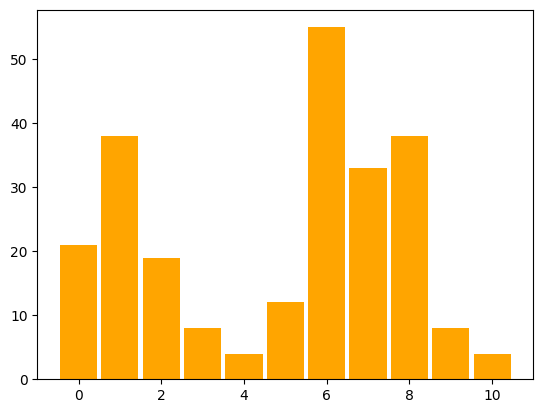

In [18]:
data_metrics = [
    6, 8, 6, 3, 8, 7,
    5, 8, 7, 8, 8, 6,
    4, 8, 1, 1, 8, 0,
    9, 6, 9, 9, 7, 8,
    6, 1, 7, 6, 1, 6,
    10, 7, 3, 7, 6, 2,
    7, 5, 5, 7, 6, 8,
    1, 7, 6, 1, 2, 1,
    6, 6, 0, 0, 6, 3,
    5, 8, 5, 1, 8, 9,
    6, 2, 6, 6, 2, 6,
    8, 2, 8, 8, 7, 8,
    0, 1, 9, 0, 1, 2,
    8, 10, 8, 9, 2, 8,
    6, 1, 8, 6, 8, 7,
    1, 5, 8, 1, 8, 6,
    7, 2, 7, 7, 6, 8,
    6, 2, 1, 6, 2, 8,
    2, 8, 2, 2, 5, 10,
    2, 6, 3, 5, 6, 1,
    1, 1, 1, 8, 1, 3,
    6, 6, 6, 6, 7, 5,
    0, 6, 0, 0, 6, 8,
    2, 6, 7, 7, 6, 3,
    7, 7, 7, 7, 7, 3,
    7, 6, 7, 7, 6, 8,
    6, 0, 0, 6, 1, 7,
    1, 6, 1, 1, 6, 7,
    1, 1, 1, 1, 1, 8,
    7, 6, 7, 7, 6, 3,
    0, 1, 0, 0, 1, 8,
    4, 1, 4, 5, 1, 6,
    6, 0, 6, 6, 10, 7,
    2, 6, 6, 2, 6, 8,
    5, 6, 5, 6, 6, 8,
    0, 8, 0, 9, 8, 9,
    1, 8, 1, 1, 8, 1,
    1, 7, 4, 1, 7, 8,
    0, 6, 0, 0, 6, 0,
    0, 6, 2, 2, 6, 8
]


plt.hist(data_metrics, bins=range(12), align='left',rwidth=0.9,color='orange')
plt.show()